In [1]:
import time
import sys
import os
from collections import OrderedDict
from importlib import reload
from pprint import pprint

import h5py
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
import qcodes
qc = qcodes

In [3]:
from scipy import constants
from scipy.interpolate import interp1d
from scipy.optimize import fmin

In [4]:
from labtools.mplplots import init_nb_plotting
reload(init_nb_plotting)
from labtools.mplplots.init_nb_plotting import *

from labtools.mplplots import plots as mplplots
from labtools.mplplots import tools as mpltools

In [ ]:
# from quantum_capacitance import rf; reload(rf)
# from quantum_capacitance.rf import AlazarMeasurementExt, AWGMeasurement, AWG2DRamp

# Basic configuration

In [6]:
%run init.py

2018-03-22 17:35:57,343 : measurement : INFO : Logger set up!


Instrument ivvi already exists.


C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:209: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '
C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:514: UserWarning: set_step is deprecated use step property as in `inst.step = stepvalue` instead
  "set_step is deprecated use step property as in `inst.step = "
C:\Users\Administrator\Code\Qcodes\qcodes\instrument\parameter.py:526: UserWarning: set_delay is deprecated use inter_delay or post_delay property as in `inst.inter_delay = delayvalue` instead
  "set_delay is deprecated use inter_delay or post_delay property "


Connected to: Keysight Technologies 34465A (serial:MY57503556, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.38s
Instrument key2 already exists.


In [219]:
station.ivvi.set_dacs_zero()

In [9]:
from pytopo.data.data_storage import Data, GridData
Data.export_spyview = True
GridData.export_spyview = True

In [10]:
station.key1.volt()

-5.73160462e-05

In [11]:
station.key1.NPLC()

10.0

In [12]:
station.key2.volt()

-0.00504753149

In [15]:
from pytopo.qctools.instruments import create_inst
from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
from visa import VisaIOError

def check_keys(ivvi):
    key1 = create_inst(Keysight_34465A, "key1", "USB0::0x2A8D::0x0101::MY57503556::INSTR", force_new_instance=True)
    key2 = create_inst(Keysight_34465A, "key2", "USB0::0x2A8D::0x0101::MY57503135::INSTR", force_new_instance=True)
    station = qc.Station(ivvi, key1, key2)
    return station

In [ ]:
station = check_keys(station.ivvi)

# Definitions

# Experiments

## DC IV traces

In [194]:
from pytopo.experiment.measurement import BaseMeasurement

class IVCurve(BaseMeasurement):
    
    start = -150.
    stop = +150
    pts = 151
    nplc = 1
    delay = 0.001
        

    def measure(self):
        try:
            self.station.key1.NPLC(self.nplc)
            self.station.key2.NPLC(self.nplc)
        except (VisaIOError, AttributeError):
            self.station = check_keys(self.station.ivvi)
            self.station.key1.NPLC(self.nplc)
            self.station.key2.NPLC(self.nplc)
        
        vals = []
        bias = np.linspace(self.start, self.stop, self.pts)

        self.station.ivvi.dac1(bias[0])
        time.sleep(1)

        t0 = time.time()
        
        for i, v in enumerate(bias):
            
            if not i%50:
                t1 = time.time() - t0
                print(f"Point {i}, t = {t1}s ...")
            
            self.station.ivvi.dac1(v)
            time.sleep(self.delay)
            try:
                amp = self.station.key1.volt()
                volt = self.station.key2.volt()
            except (VisaIOError, AttributeError):
                self.station = check_keys(self.station.ivvi)
                amp = self.station.key1.volt()
                volt = self.station.key2.volt()
            
            self.data.add(
            OrderedDict({
                'Bias' : {'value' : v * 1e-6, "unit": 'V', "independent_parameter": True},
                'Current' : {'value' : amp * 1e-7, "unit": 'A'},
                'Voltage' : {'value' : volt, 'unit' : 'V'},
                })
            )
            
            

# class IMonitor(BaseMeasurement):
    
#     npts = 100
#     nplc = 10
#     delay = 0.01
#     bias = 170  
        
#     def measure(self):
#         try:
#             self.station.key1.NPLC(self.nplc)
#             self.station.key2.NPLC(self.nplc)
#         except (VisaIOError, AttributeError):
#             self.station = check_keys(self.station.ivvi)
#             self.station.key1.NPLC(self.nplc)
#             self.station.key2.NPLC(self.nplc)
        
#         self.station.ivvi.dac1(self.bias)
#         time.sleep(1)
#         t0 = time.time()
        
#         for i in range(self.npts):
#             time.sleep(self.delay)
            
#             try:
#                 amp = self.station.key1.volt()
#                 volt = self.station.key2.volt()
#             except (VisaIOError, AttributeError):
#                 self.station = check_keys(self.station.ivvi)
#                 amp = self.station.key1.volt()
#                 volt = self.station.key2.volt()
            
#             self.data.add(
#                 OrderedDict({
#                     'time' : {'value' : time.time() - t0, "unit": 's', "independent_parameter": True},
#                     'Current' : {'value' : amp * 1e-7, "unit": 'A'},
#                     'Voltage' : {'value' : volt, 'unit' : 'V'},
#                     })
#             )

In [187]:
def smooth(x, window_len=10):
    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    w = np.ones(window_len,'d')
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[int(window_len/2-1):int(-window_len/2)]


def process_data(bias, current, voltage, R, smooth_win=50):    
    bias *= 1e6
    voltage *= 1e6
    voltage -= voltage.mean()
    current *= 1e9
    current -= current[current.size//2]

    iof, bof = find_offset(current, bias, smooth_win=smooth_win)
    print(iof, bof)
    bias -= bof
    
    bias -= current * R * 1e-3

    _, vof = find_offset(current, voltage, smooth_win=smooth_win)
    voltage -= vof
#     current -= iof
    print(vof)
    
    return bias, current, voltage


def find_offset(i, v, i_th=0.05, delta=1e-9, max_it=100, smooth_win=50):
    ifunc = interp1d(v, smooth(i, smooth_win), fill_value='extrapolate')
    v_guess = v[np.argmin(abs(i-i_th))] 
#     print(v_guess)
    v_pos = v_guess
    v_neg = -v_guess
    v_of = 0
    i_of = 0
    
    for k in range(max_it):
        print(k, v_of, i_of)
        
        # for each iteration:
        # 1) using current i/v offsets, find v where i exceeds the threshold (both pos and neg side)
        # 2) update the v-offset by adding the mean of the new found values to the current one
        # 3) update i-offset (just the function value of i at the new 'zero' v value)
        v_pos = fmin(lambda v: abs(ifunc(v+v_of)-i_th-i_of), v_pos, disp=0, xtol=1e-8, ftol=1e-8)
        v_neg = fmin(lambda v: abs(ifunc(v+v_of)+i_th-i_of), v_neg, disp=0, xtol=1e-8, ftol=1e-8)
        v_of_new = v_of + (v_pos+v_neg)/2.
        
        if abs(v_of - v_of_new) < delta:
            v_of = v_of_new
            i_of = ifunc(v_of)
            break

        v_of = v_of_new
        i_of = ifunc(v_of)
        
        return i_of, v_of
    

def fit_linslope(i, v, ilim=None, vlim=None):  
    if ilim is not None:
        fltr = (i>ilim[0]) & (i<ilim[1])
    elif vlim is not None:
        fltr = (v>vlim[0]) & (v<vlim[1])
    else:
        fltr = slice(None, None, None)
        
    i2 = i[fltr]
    v2 = v[fltr]
    
    p = np.polyfit(np.log(i2[i2>0]), v2[i2>0], 1)
    i_linfit = np.exp((v2-p[1])/p[0])
    T_slope = constants.e * p[0] * 1e-6 / constants.k
    
    return v2, i_linfit, T_slope

2018-03-23 16:22:55,267 : measurement : INFO : Ready to measure, file location: d:\data\2018-03\2018-03-23\2018-03-23_IVCurve-#0005__NIS-1_250pts_only_positive_10NPLC...


Point 0, t = 0.0s ...
Point 50, t = 43.79679536819458s ...
Point 100, t = 87.59215140342712s ...
Point 150, t = 131.64975094795227s ...
Point 200, t = 175.7569136619568s ...
Point 250, t = 219.775803565979s ...


2018-03-23 16:26:38,480 : measurement : INFO : Measurement finished, cleaning up...
2018-03-23 16:26:38,661 : measurement : INFO : All done!


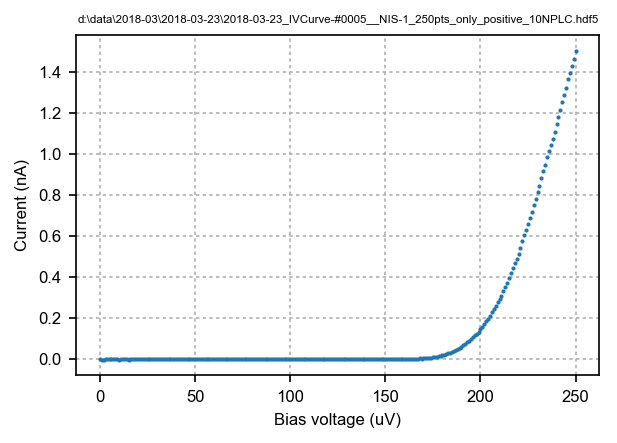

In [210]:
# T = 100
# t0 = time.time()
# delay = 5

t0 = time.time()
idx = 0

# while True:

#     for avgs in [201, 401, 801, 1601]:
    
### measure IV trace
m = IVCurve(station, namespace, info_string=f'_NIS-1_250pts_only_positive_10NPLC')
m.start = 0
m.stop = 250
m.pts = 251
m.nplc = 10
m.delay = 0.01
m.run()

bias = m.data['Current']['Bias [V]'].reshape(-1).copy()
i = m.data['Current']['Current [A]'].reshape(-1).copy()
v = m.data['Voltage']['Voltage [V]'].reshape(-1).copy()

i -= i[i.size//2]
bias *= 1e6
i *= 1e9

fig, ax = plt.subplots(1, 1)
ax.plot(bias, i, 'o', ms=1)
ax.set_xlabel('Bias voltage (uV)')
ax.set_ylabel('Current (nA)')
ax.set_title(m.datafilepath, size='x-small')
ax.grid(dashes=[2,2])


# bias = m.data['Current']['Bias [V]'].reshape(-1).copy()
# i = m.data['Current']['Current [A]'].reshape(-1).copy()
# v = m.data['Voltage']['Voltage [V]'].reshape(-1).copy()# fig.savefig(m.data_prefix + ".png", dpi=300)

0 0 0
[-0.00134743] [ 0.15691737]
0 0 0
[-4.46383737]


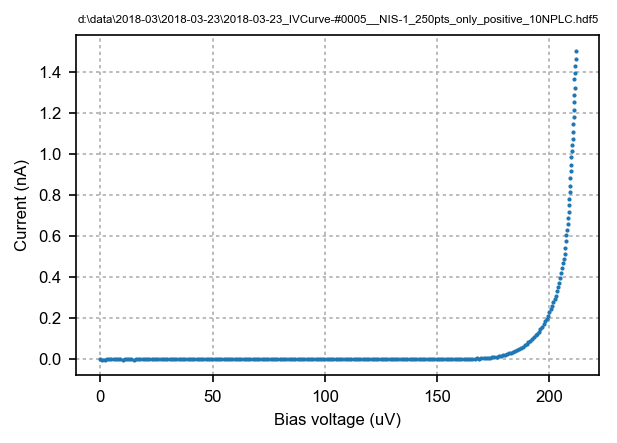

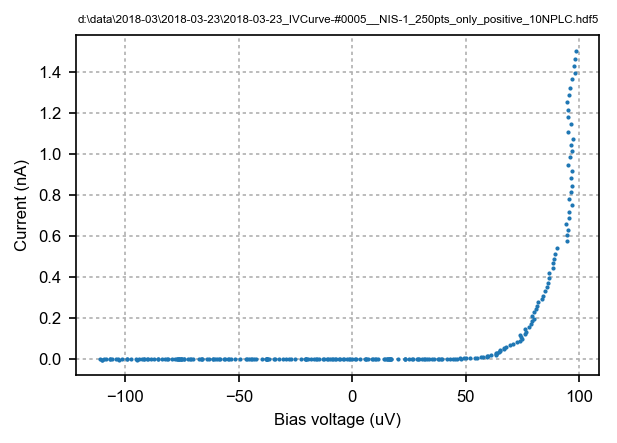

In [211]:
R = 12e3 + 2*(5e3  + 1.7e3)

bias = m.data['Current']['Bias [V]'].reshape(-1).copy()
i = m.data['Current']['Current [A]'].reshape(-1).copy()
v = m.data['Voltage']['Voltage [V]'].reshape(-1).copy()

bias2, i2, v2 = process_data(bias, i, v, R, smooth_win=10)

fig, ax = plt.subplots(1, 1)
ax.plot(bias2, i2, 'o', ms=1)
ax.set_xlabel('Bias voltage (uV)')
ax.set_ylabel('Current (nA)')
ax.set_title(m.datafilepath, size='x-small')
ax.grid(dashes=[2,2])

fig, ax = plt.subplots(1, 1)
ax.plot(v2, i2, 'o', ms=1)
ax.set_xlabel('Bias voltage (uV)')
ax.set_ylabel('Current (nA)')
ax.set_title(m.datafilepath, size='x-small')
ax.grid(dashes=[2,2])

0.0847222234337


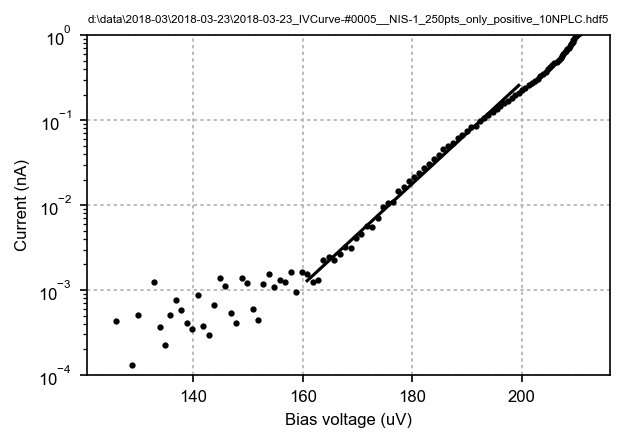

In [218]:
b_0, i_0 = bias2[bias2.size//2:], i2[i2.size//2:]
b_1, i_1 = -bias2[:bias2.size//2], -i2[:i2.size//2]
b_2, i_2 = v2[v2.size//2:], i2[i2.size//2:]
b_3, i_3 = -v2[:v2.size//2], -i2[:i2.size//2]


fig, ax = plt.subplots(1, 1)

ax.plot(b_0, i_0, 'ko', ms=2)
# ax.plot(b_1, i_1, 'ro', ms=2)
# ax.plot(b_2, i_2, 'bo', ms=2)
# ax.plot(b_3, i_3, 'go', ms=2)

bfit_0, ifit_0, T_0 = fit_linslope(i_0, b_0, vlim=(160, 200))
ax.plot(bfit_0, ifit_0, 'k-')
print(T_0)

# bfit_1, ifit_1, T_1 = fit_linslope(i_1, b_1, vlim=(160, 200))
# ax.plot(bfit_1, ifit_1, 'r-')
# print(T_1)

# bfit_2, ifit_2, T_2 = fit_linslope(i_2, b_2, vlim=(160, 200))
# ax.plot(bfit_2, ifit_2, 'b-')
# print(T_2)

# bfit_3, ifit_3, T_3 = fit_linslope(i_3, b_3, vlim=(160, 200))
# ax.plot(bfit_3, ifit_3, 'b-')
# print(T_3)

ax.set_xlabel('Bias voltage (uV)')
ax.set_ylabel('Current (nA)')
ax.set_yscale('log')

# ax.set_xlim(100, 220)
ax.set_ylim(1e-4, 1)

ax.set_title(m.datafilepath, size='x-small')
ax.grid(dashes=[2,2])

In [192]:
100 * 1e-3 * 5000

500.0

In [193]:
49%50

49